In [1]:
using Sunny
using BinningAnalysis
using GLMakie
Makie.inline!(true)

# include plotting function for chirality heatmaps
include(joinpath(pkgdir(Sunny), "examples", "extra", "plotting2d.jl"))
z_mean(s1, s2, s3) = (s1[3] + s2[3] + s3[3]) / 3

z_mean (generic function with 1 method)

### The 'Okubo' model (https://arxiv.org/abs/1109.6161v2)

As an interesting example, let's look at a $J_1$-$J_3$ Heisenberg model on a triangular lattice with Hamiltonian: 

\begin{equation}
\mathcal{H} = J_1 \sum\limits_{\left<i,j\right>} \vec{S}_i\cdot\vec{S}_j + J_3\sum\limits_{\left<\left<i,j\right>\right>}\vec{S}_i\cdot\vec{S}_j - H\sum\limits_i\vec{S}_i 
\end{equation}

This should exhibit interesting skyrmion and spiral orderings.

In [2]:
# setup 2D triangular lattice
a, c = 1.0, 10.0
latvecs = lattice_vectors(a, a, c, 90, 90, 120)
positions = [[0, 0, 0]]
cryst = Crystal(latvecs, positions)

# setup 2D system 
L = 72
sys = System(cryst, (L, L, 1), [SpinInfo(1; S=1, g=1,)], :dipole, units=Units.theory, seed=0)
N = length(sys.dipoles)

# ferromagnetic nearest neighbor exchange interaction
J₁ = -1
set_exchange!(sys, J₁, Bond(1, 1, [1,0,0]))
# antiferromagnetic third-nearest neighbor exchange interaction
J₃ = 3.0 * abs(J₁)
set_exchange!(sys, J₃, Bond(1, 1, [2,0,0]))

# external magnetic field
h = 2.0 * J₃
set_external_field!(sys, [0, 0, h])

# start with random spin state
randomize_spins!(sys)

### Parallel Tempering Algorithm

As motivation, let's remember some of the practical difficulties with Metropolis MC and simulated annealing. When using Metropolis MC, there can be long correlation times, and the system can get trapped entirely when sampling at low temperatures. In simulated annealing, we likely will not be able to lower the temperature slow enough to avoid getting trapped in a local minimum, and determining an appropriate temperature schedule is nontrivial. 

The parallel tempering algorithm is a method that can overcome trapping in local free energy minima, and lets the simulated system move up and down in temperature in a way that satisfies detailed balance. The idea is to simulate copies, or replicas, of the system at different temperatures in parallel, and swap their configurations. This lets systems at lower temperatures move to a higher temperature and thermalize, before tempering back down to low temperature again with a decorrelated configuration.

Each replica is assigned its own inverse temperature, $\beta = 1 / (k_BT)$, and performs a simulation using something like Metropolis MC or Langevin dynamics. At some specified frequency, a swap of configurations between neighboring replicas, or replica exchange, is attempted and accepted as: 

\begin{equation}
    p_{exch}(\boldsymbol{x}\leftrightarrow\boldsymbol{x'}; \beta, \beta') = \min\left(1,\; e^{\Delta\beta\Delta E}\right)\;\;.
\end{equation}

This expression depends on how far apart the neighboring replicas are in inverse temperature, $\Delta\beta = \beta' - \beta$, and energy, $\Delta E = E(\boldsymbol{x}') - E(\boldsymbol{x})$. 

We will explore the use of this algorithm in Sunny, which implements it using Julia's multithreading capabilities. Currently, you can use either a `LocalSampler` or `Langevin` type as a driver for each replica. It will be reiterated, but this method works best on a machine with many available threads, such as a node on a HPC cluster.

To use Metropolis MC as the driver for each replica, set up a `LocalSampler` as usual. It doesn't matter what the temperature is set to initially, as this will be reset when we initialize parallel tempering.

In [3]:
# choose a mix of MC moves: 50% randomized on sphere, 50% on a spherical cap
move_proposal = @mix_proposals 0.2 propose_uniform 0.8 propose_delta(0.25) 

# use a metropolis sampler 
sampler = LocalSampler(; kT=0, propose=move_proposal);

This sampler will be cloned for each replica in parallel tempering, and we need to specify how many replicas to use in the simulation. This is an important choice, and a rule of thumb would be to use $\sim \sqrt{N}$, where $N$ is the number of spins in the system. 

You can set the number of replicas to be greater than the number of threads on your machine and a threadpool will designate work to available threads.

Ideally, we would run the simulation using all threads on an HPC cluster by adding a `-t <n_replicas>` flag to the command line. This way, each replica has its own thread and the work can be parallelized. 

If running in VSCode on a laptop, set the number of threads by hitting `Ctrl+Shift+P` and selecting `Preferences: Open User Settings (JSON)`, then find the line `julia.NumThreads` to set a value. You can set the value to "auto" to use all threads on your machine. 

You can also do: `IJulia.installkernel( "Julia 12 Threads", env=Dict("JULIA_NUM_THREADS" => "12",) )`.

In [4]:
# can be larger than number of cores on machine
n_replicas = 80

println("simulate $(n_replicas) replicas using $(Threads.nthreads()) threads")

simulate 80 replicas using 1 threads


Since each replicas simulates at its own temperature, we need to choose a temperature schedule. The choice of these temperatures can actually be very important, but this will be discussed later. Let's choose a linear schedule to begin with. 

Because of the discretized temperature schedule, we may actually be interested in temperature points that are not explicitly measured parallel tempering. There is a method in Sunny for addressing this that will not be discussed here. Let's say that we're interested in the temperature $k_BT/J_3 = 0.35$ that we looked at for this system with Metropolis MC.

In [5]:
# temperature schedule for parallel tempering
kT_min, kT_max = (1e-2 * J₃), (0.75 * J₃)
kT_sched = collect(range(kT_min, kT_max, length=n_replicas))

kT = 0.35 * J₃
id_measure = argmin(abs.(kT_sched .- kT))
println("data measured at kT/J₃ = ", kT_sched[id_measure]/J₃, " vs. interested at kT/J₃ = ", kT/J₃)

data measured at kT/J₃ = 0.3472151898734177 vs. interested at kT/J₃ = 0.3499999999999999


The functions for parallel tempering are not exported. We can access the constructor by `Sunny.ParallelTempering`. This will create a `ParallelTempering` called `PT` type which has an array of samplers stored in `PT.samplers`, and array of systems (replicas) in `PT.systems`. 

The replica exchanges are implemented storing an array of indices that tells which replica is currently at each sampler. This is stored in `PT.system_ids`.

In [6]:
# initialize parallel tempering 
PT = Sunny.ParallelTempering(sys, sampler, kT_sched);

### Equilibration and Sampling at a Temperature

Just like with Metropolis MC, we need to equilibrate each replica to its respective temperature. We will use an initial parallel tempering simulation to do this. 

Instead of advancing the state of a `LocalSampler` with the `step!(::System, ::LocalSampler)` function, there is an equivalent which does so for a `ParallelTempering` type while making attempting replica exchanges at a specified interval. This is the `Sunny.step_ensemble!(::ParallelTempering, ::Int64, ::Int64)` function, where the last two arguments are the number of sweeps sampled and the replica-exchange interval.

Currently, the replica-exchange interval should be less than or equal to the number of sweeps passed. We will equilibrate the replicas and periodically record the energy time series. 

This equilibration will take about 2 minutes.

In [7]:
# sampling parameters
n_init = 6_000
exch_interval = 10
measure_interval = 2*exch_interval
n_measure = cld(n_init, measure_interval)

# energy timeseries
Evt_init = zeros(n_measure, n_replicas)

# perform equilibration using parallel tempering MC
for i in 1:n_measure
    Sunny.step_ensemble!(PT, measure_interval, exch_interval)
    Evt_init[i, :] .= getproperty.(PT.samplers, :ΔE) ./ N
end

Let's look at the energy equilibration plot and equilibrated state for our temperature of interest.

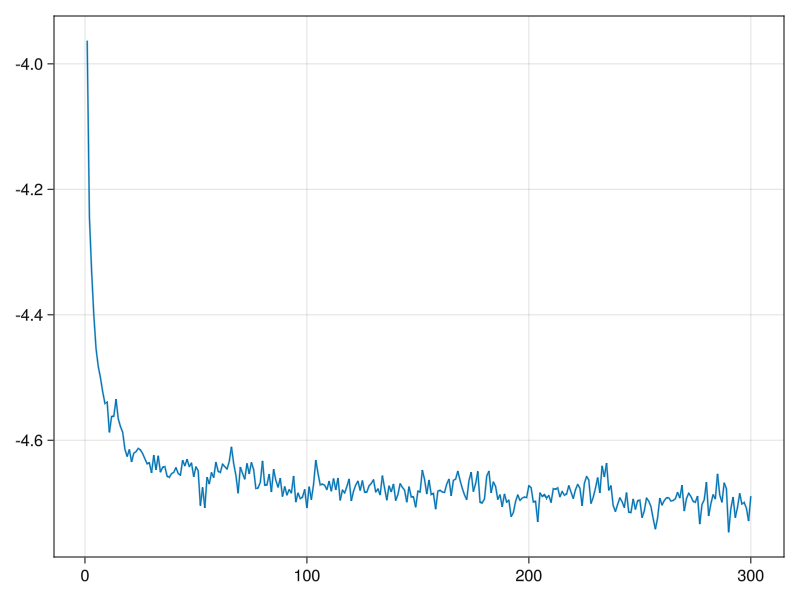

GLMakie.Screen(...)

In [8]:
fig = Figure()
lines(fig[1,1], 1:n_measure, Evt_init[:,id_measure])
display(fig)

E = -4.68891542852599


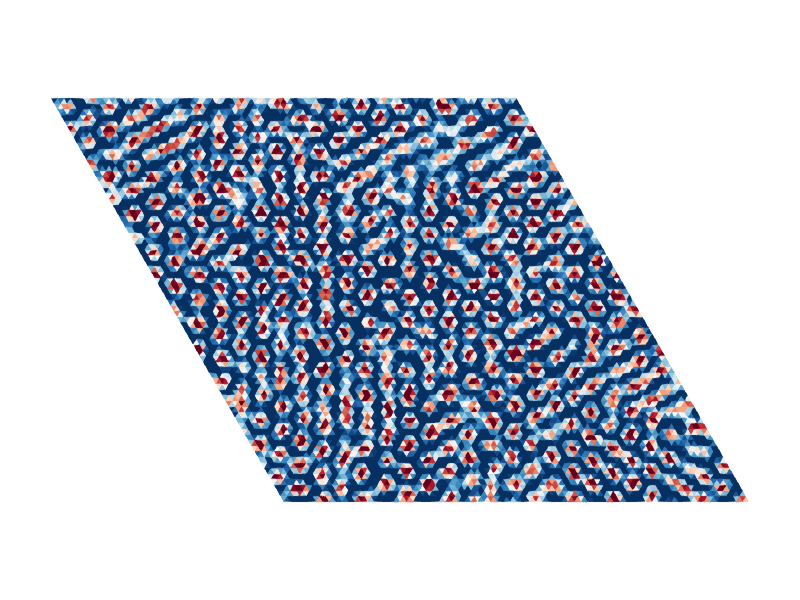

In [9]:
println("E = ", PT.samplers[id_measure].ΔE/N)
plot_triangular_plaquettes(z_mean, [PT.systems[PT.system_ids[id_measure]].dipoles])

The power of parallel tempering comes from the replica-exchanges, which allows the system to overcome free energy barriers by diffusing up and down in temperature space. It's important to have an idea of how many replica exchanges are being accepted at each temperature point. 

The function `get_statistics(::ParallelTempering)` will return $A_{i,i+1}$, which has length `n_replicas-1` and contains the replica-exchange acceptance rate between each replica $i$ and its neighbor $i+1$ (omitting last replica). If there are points where $A_{i,i+1} \approx 0$, this means that the algorithm is failing to send over configurations to that temperature (ex: first-order phase transitions).

This quantity is plotted for our equilibration run, but we want to reset it with `reset_statistics!(::ParallelTempering)` before moving on to our production simulation for measurements. 

In [10]:
function get_statistics(PT::Sunny.ParallelTempering)
    return PT.n_accept[1:end-1] ./ PT.n_exch[1:end-1]
end

function reset_statistics!(PT::Sunny.ParallelTempering)
    PT.n_accept .= 0
    PT.n_exch .= 0
    return nothing 
end

reset_statistics! (generic function with 1 method)

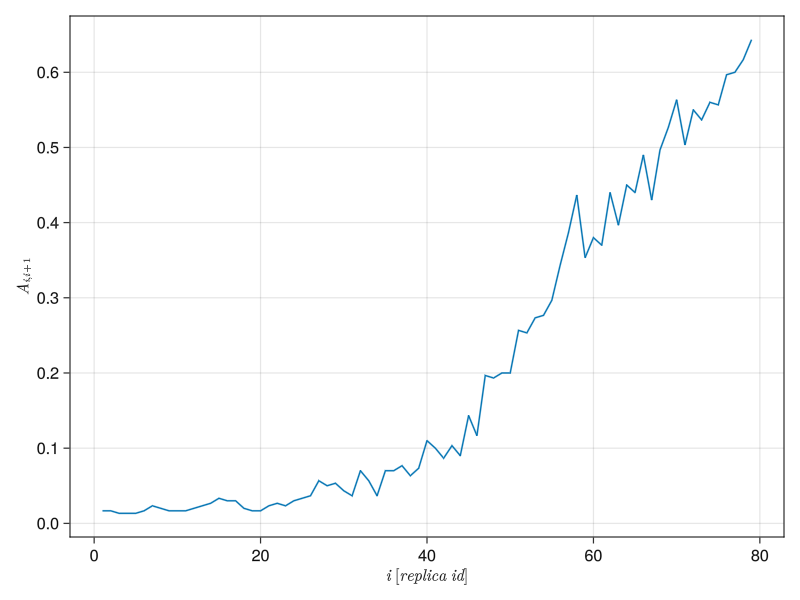

replica-exchange acceptance = 0.07666666666666666 at kT/J₃ = 0.35
minimum replica-exchange acceptance: 0.013333333333333334


In [11]:
# replica-exchange acceptance 
A_exch = get_statistics(PT)

fig = Figure()
lines(fig[1,1], 1:n_replicas-1, A_exch, axis=(xlabel=L"i\;[replica\;id]", ylabel=L"A_{i, i+1}"))
display(fig)

println("replica-exchange acceptance = ", A_exch[id_measure], " at kT/J₃ = 0.35")
println("minimum replica-exchange acceptance: ", minimum(A_exch))

reset_statistics!(PT);

Now we can start taking measurements at each of the temperatures in the parallel tempering simulation. This is another advantage over simple Metropolis MC - we can quickly calculate ensemble averages for a range of temperatures. 

The way the code is set up, is that the user must write a simulation loop and collect measurements themselves. Let's do this for our example. We will measure the internal energy, the average magnetization, and the distribution of energies at each temperature. Let's also measure the autocorrelation times and compare the value at $k_BT/J_3 = 0.35$ with our previous Metropolis MC calculations.  

This simulation take me 1.5 minute running on a M1 with 4 threads.

In [12]:
# sampling parameters
n_measure = 2_000
exch_interval = 1
measure_interval = 2*exch_interval
n_steps = n_measure * measure_interval

# energy histograms for each replica -- choose a binning size
E_hists = [ Sunny.Histogram(bin_size=5e-3) for _ in 1:n_replicas ]
# binners for calculating energy autocorrelation times
binners = [ LogBinner() for _ in 1:n_replicas ]
# average energy per spin 
U = zeros(n_replicas)
# average magnitude of magnetization per spin
M = zeros(n_replicas)

# start parallel tempering simulation for measurements 
for n in 1:n_measure
    (n % 100 == 0) && println(n, " measurements")
    Sunny.step_ensemble!(PT, measure_interval, exch_interval)

    for i in 1:n_replicas
        E = PT.samplers[i].ΔE / N
        m = norm(sum(PT.systems[PT.system_ids[i]].dipoles)) / N

        U[i] += E
        M[i] += m 
        E_hists[i][E] += 1
        push!(binners[i], E)
    end
end
U ./= n_measure
M ./= n_measure

τ = tau.(binners) .* measure_interval;

100 measurements


200 measurements


300 measurements


400 measurements


500 measurements


600 measurements


700 measurements


800 measurements


900 measurements


1000 measurements


1100 measurements


1200 measurements


1300 measurements


1400 measurements


1500 measurements


1600 measurements


1700 measurements


1800 measurements


1900 measurements


2000 measurements


The thermodynamics, while for a relatively small system size, show two transitions: paramagnetic to the skyrmion crystal phase, which then transitions to a single-q ordering.

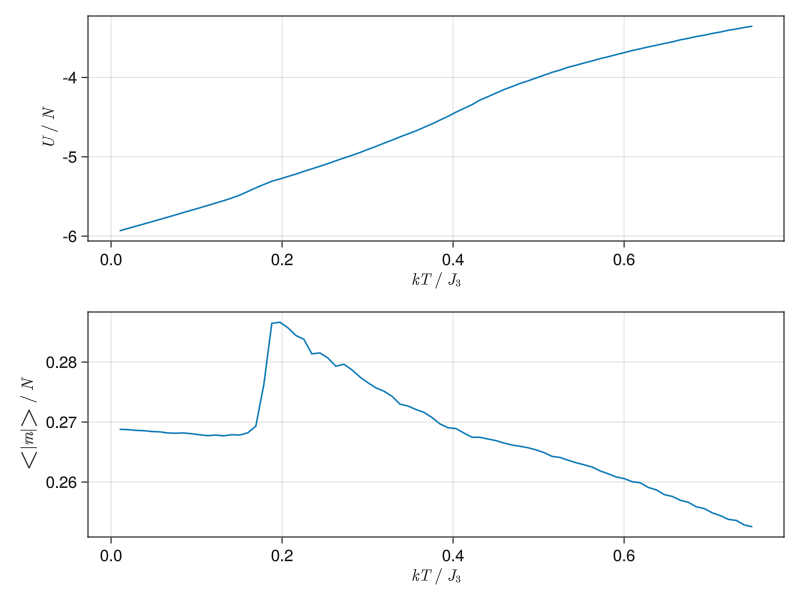

GLMakie.Screen(...)

In [13]:
fig = Figure()
lines(fig[1,1], (kT_sched ./ J₃), U, axis=(xlabel=L"kT\;/\;J_3", ylabel=L"U\;/\;N")) 
lines(fig[2,1], (kT_sched ./ J₃), M, axis=(xlabel=L"kT\;/\;J_3", ylabel=L"\left<|m|\right>\;/\;N"))
display(fig)

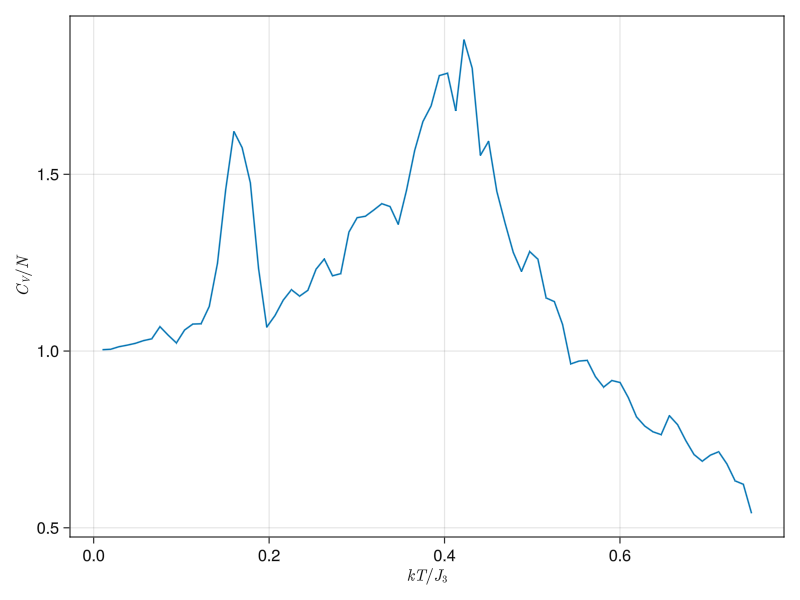

GLMakie.Screen(...)

In [14]:
# using the method described in numpy's gradient documentation
function finite_diff(x::Vector{Float64}, y::Vector{Float64})
    N = length(x)
    dydx = zeros(N)

    for i in 2:N-1
        dx₋ = x[i] - x[i-1]
        dx₊ = x[i+1] - x[i]
        dydx[i] = (dx₋^2 * y[i+1] + (dx₊^2 - dx₋^2) * y[i] - dx₊^2 * y[i-1]) / (dx₋ * dx₊ * (dx₊ + dx₋))
    end
    dydx[1] = (y[2] - y[1]) / (x[2] - x[1])
    dydx[N] = (y[N] - y[N-1]) / (x[N] - x[N-1])

    return dydx
end

C = finite_diff(kT_sched, U)

fig = Figure()
lines(fig[1,1], kT_sched ./ J₃, C, axis=(xlabel=L"kT/J_3", ylabel=L"C_V / N"))
display(fig)

The calculated autocorrelation times, $\tau$ are quite noisy, as they were estimated from a very small number of data. Taken with a grain of salt, the value of $\tau$ at $T = 0.2J_3$ is now half of what was reported with Metropolis MC. 

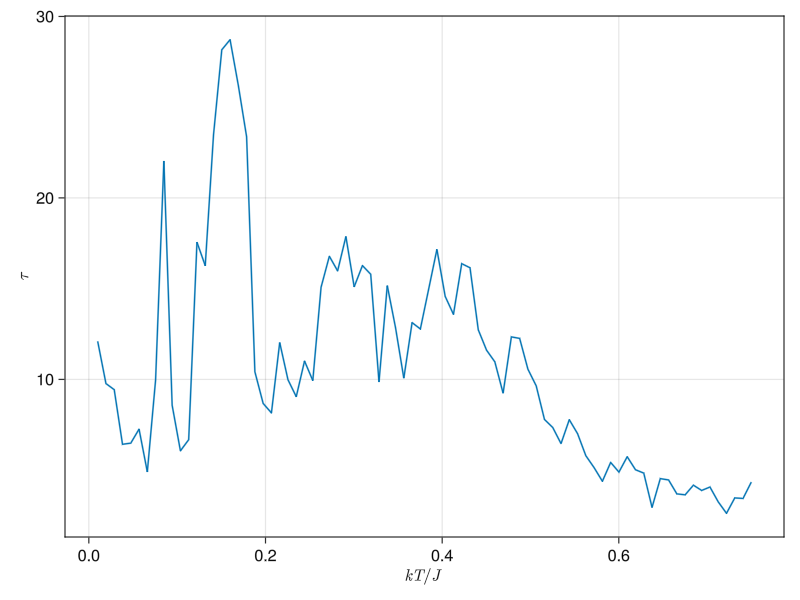

τ = 12.845210264676965 at kT/J₃ = 0.35


In [15]:
fig = Figure()
lines(fig[1,1], (kT_sched ./ J₃), τ, axis=(xlabel=L"kT/J₃", ylabel=L"τ"))
display(fig)

println("τ = ", τ[id_measure], " at kT/J₃ = 0.35")

Perhaps the most visually informative, the energy distributions for each replica show the level of overlap with their neighboring replicas. As the temperature decreases, we see that there is practically no overlap between neighboring distributions, which will manifest as a negligible replica-exchange acceptance rate.

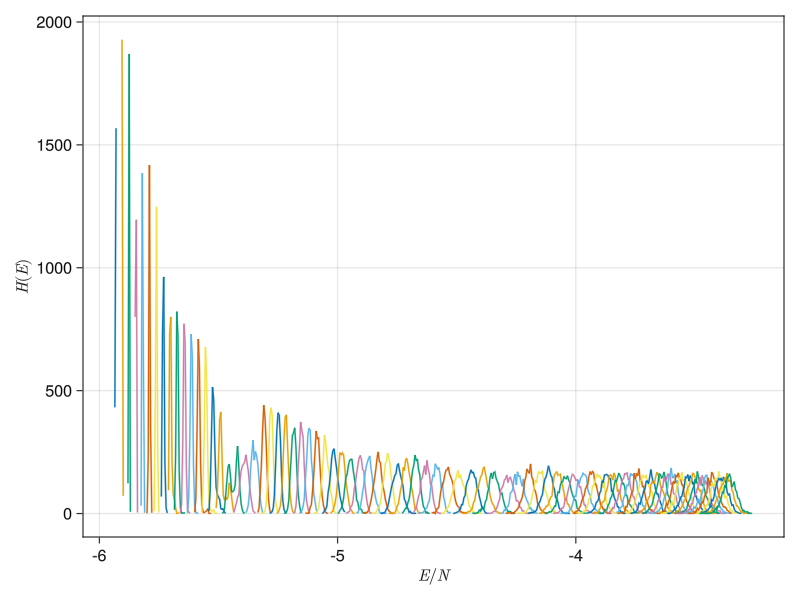

GLMakie.Screen(...)

In [16]:
fig = Figure()
Axis(fig[1,1], xlabel=L"E / N", ylabel=L"H(E)")
for H in E_hists
    lines!(Sunny.get_keys(H), Sunny.get_vals(H))
end
display(fig)

Indeed, looking at the parallel tempering acceptance rates shows that state information is mostly not being exchanged for the first $\sim 20$ replicas. 

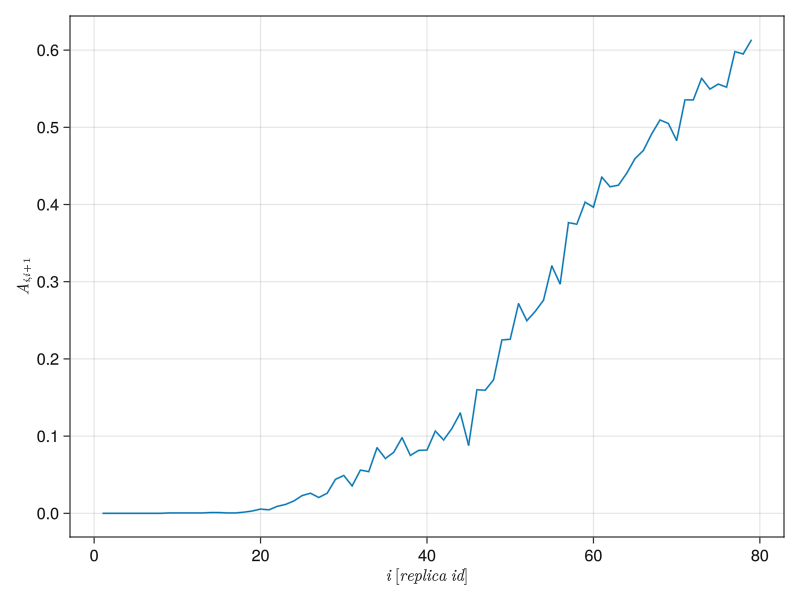

replica-exchange acceptance = 0.098 at kT/J₃ = 0.35
minimum replica-exchange acceptance: 0.0


In [17]:
# replica-exchange acceptance 
A_exch = get_statistics(PT)

fig = Figure()
lines(fig[1,1], 1:n_replicas-1, A_exch, axis=(xlabel=L"i\;[replica\;id]", ylabel=L"A_{i, i+1}"))
display(fig)

println("replica-exchange acceptance = ", A_exch[id_measure], " at kT/J₃ = 0.35")
println("minimum replica-exchange acceptance: ", minimum(A_exch))